# PPI power analysis

This notebook demonstrates the PPI power analysis from [3, Section 3]. The power analysis returns two samples sizes: $n$ - the size of the labeled (or gold-standard) dataset and $N$ - the size of unlabeled dataset. The power analysis is for PPI++ with power tuning [2, Section 6].

Two types of power analysis are implemented, the most powerful pair and the cheapest pair. The **most powerful pair** returns the pair $(n, N)$ that minimizes the standard error of the PPI estimator subject to a constraint on the cost. The **cheapest pair** returns the pair $(n, N)$ that minimizes the cost subject to a constraint on the standard error.

The power analysis also returns two measurements of the effectiveness of PPI. These are the PPI correlation and the effective sample size. The **PPI correlation** measures the similarity between the estimate derived from the labeled data and the estimate based on the predictions. The **effective sample size** is the number of labels that would be needed for classical inference to achieve the same level of power as PPI with `n` labels and `N` predictions.

The full output from any of the power analysis functions is a dictionary containing:
* `n` -- the size of the labeled dataset
* `N` -- the size of the unlabeled dataset
* `cost` -- the total cost of gathering the two datasets and performing PPI
*  `se` -- the standard error of the PPI point estimate with `n` labels and `N` predictions
* `ppi_corr` -- the PPI correlation
* `effective_n` -- the effective sample size

The power analysis is **data-driven**. To perform the power analysis, the user must supply a preliminary dataset with both labels $Y_i$ and predictions $f(X_i)$. The power analysis then returns the optimal pair $(n, N)$ for a new experiment.

The power analysis is implemented for inference on the mean, linear regression coefficients, and generalized linear model coefficients. Functions are named `ppi_<estimand>_power`. There is also a generic function `ppi_power` that allows the user to specify the PPI correlation.
    
References 
* [1] Angelopoulos, A. N., Bates, S., Fannjiang, C., Jordan, M. I., & Zrnic, T. (2023). Prediction-powered inference. Science, 382(6671), 669-674.  https://www.science.org/doi/full/10.1126/science.adi6000 
* [2] Angelopoulos, A. N., Duchi, J. C., & Zrnic, T. (2023). PPI++: Efficient prediction-powered inference. https://arxiv.org/abs/2311.01453
* [3] Broska, D., Howes, M., & van Loon, A. (2024). The Mixed Subjects Design: Treating Large Language Models as  (Potentially) Informative Observations. https://doi.org/10.31235/osf.io/j3bnt



In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import matplotlib.pyplot as plt
from ppi_py.datasets import load_dataset
from ppi_py.power_ppi import (
    ppi_power,
    ppi_mean_power,
    ppi_ols_power,
    ppi_poisson_power,
)
from utils import *
import warnings

warnings.simplefilter("always", UserWarning)
np.random.seed(0)  # For reproducibility

## Power analysis for the mean

The function `ppi_mean_power` performs a power analysis for estimating the mean of $Y$. The functionality is similar to all `ppi_<estimand>_power` functions.



The inputs for `ppi_mean_power` are
* `Y` -- the labels $\{Y_i\}_{i=1}^n$
* `Yhat` -- the predictions on the labeled data $\{f(X_i)\}_{i=1}^n$
* `Yhat_unlabeled` -- the predictions on unlabeled data $\{f(\widetilde{X}_i)\}_{i=1}^N$
* `cost_Y` -- the cost of a label $Y_i$
* `cost_Yhat` -- the cost of a prediction $f(X_i)$
* Either `budget` (for the most powerful pair) or `se` (for the cheapest pair)


### The most powerful pair

The most powerful pair is computed by giving `budget` as an input to `ppi_power_mean`. The below code computes the most powerful pair assuming `cost_Y = 1`, `cost_Yhat = 0.1` and `budget = 1000`. These costs mean that predictions are ten times cheaper than labels and that the budget can buy 1,000 labeled samples. In this example, using PPI with the optimal sample sizes is equivalent to having over 3,000 labeled samples.



In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "ballots")
Y = data["Y"]
Yhat = data["Yhat"]
Yhat_unlabeled = data["Yhat_unlabeled"]

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]

n_initial = 500
N_initial = 500

labeled_initial = np.random.choice(n, n_initial, replace=False)
unlabeled_initial = np.random.choice(N, N_initial, replace=False)

Y_initial = Y[labeled_initial]
Yhat_initial = Yhat[labeled_initial]
Yhat_unlabeled_initial = Yhat_unlabeled[unlabeled_initial]

budget = 1000
cost_Y = 1
cost_Yhat = 0.1

powerful_pair = ppi_mean_power(
    Y_initial,
    Yhat_initial,
    Yhat_unlabeled_initial,
    cost_Y,
    cost_Yhat,
    budget=budget,
)

powerful_pair

{'n': 444,
 'N': 5112,
 'cost': 999.6,
 'se': 0.008487472148317653,
 'ppi_corr': 0.9694815407698035,
 'effective_n': 3283}

The below plot shows optimality of the most powerful pair. The pair of sample sizes $(n, N)$ achieves the budget and gives the smallest possible standard error within the budget.

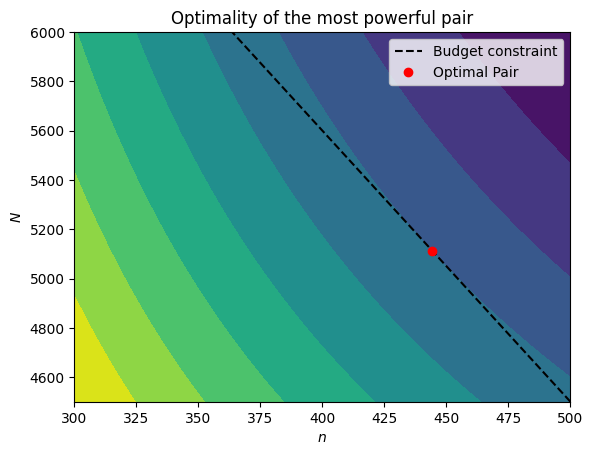

In [3]:
n_opt = powerful_pair["n"]
N_opt = powerful_pair["N"]
rho = powerful_pair["ppi_corr"]

n = np.linspace(300, 500, 100)
N = np.linspace(4500, 6000, 100)

ns, Ns = np.meshgrid(n, N)


def ppi_se(n, N, rho):
    return np.sqrt(1 / n * (1 - rho**2 * N / (n + N)))


ses = ppi_se(ns, Ns, rho)
m = np.min(ses)
M = np.max(ses)
se_opt = ppi_se(n_opt, N_opt, rho)
levels = np.concat([np.linspace(m, se_opt, 4), np.linspace(se_opt, M, 7)[1:]])

plt.contourf(ns, Ns, ses, levels=levels)

n_cost = (budget - (cost_Yhat * N)) / (cost_Yhat + cost_Y)
plt.plot(n_cost, N, "k--", label="Budget constraint")

plt.plot(n_opt, N_opt, "ro", label="Optimal Pair")

plt.xlabel("$n$")
plt.ylabel("$N$")
plt.title("Optimality of the most powerful pair")
plt.legend()
plt.show()

### The cheapest pair

The cheapest pair is computed by using the input `se` instead of the input `budget`. The below code computes the cheapest pair achieving a standard error of $0.0025$. The preliminary data and costs are taken from the previous example.


In [4]:
se = 0.0025
cheapest_pair = ppi_mean_power(
    Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, se=se
)
cheapest_pair

{'n': 5119,
 'N': 58899,
 'cost': 11520.8,
 'se': 0.0025000583354539314,
 'ppi_corr': 0.9694815407698035,
 'effective_n': 37845}

## Power analysis for regression coefficients

The functions `ppi_<estimand>_power` perform the PPI power analysis for other estimands. The currently implemented estimands are

* Linear regression `ppi_ols_power`
* Logisitic regression `ppi_logisitic_power`
* Poisson regression `ppi_poisson_power`

These power analyses are data driven. The inputs for `ppi_<estimand>_power` are:

* `X` -- the covariates for the labeled data
* `Y` -- the labels $\{Y_i\}_{i=1}^n$
* `Yhat` -- the predictions on the labeled data $\{f(X_i)\}_{i=1}^n$
* `X_unlabeled` -- the covariates for the unlabeled data
* `Yhat_unlabeled` -- the predictions on unlabeled data $\{f(\widetilde{X}_i)\}_{i=1}^N$
* `cost_X` -- the cost of an unlabeled data point $X_i$
* `cost_Y` -- the cost of a label $Y_i$
* `cost_Yhat` -- the cost of a prediction $f(X_i)$
* `coord` -- the index of the regression coefficient of interest. If `X` is `d` dimensional, `coord` must be one of `0, 1, ... , d-1`
* Either `budget` (for the most powerful pair) or `se` (for the cheapest pair)


### Power analysis for linear regression

The function `ppi_ols_power` performs a data-driven power analysis for linear regression. This is illustrated using the `census_income` dataset from [1]. The cheapest pair $(n, N)$ achieving a standard error of 50 is computed.

In [5]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 750
N_initial = 750

sample = np.random.choice(n_total, n_initial + N_initial, replace=False)
Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]


cost_X = 0.01
cost_Y = 1
cost_Yhat = 0.01
coord = 0
se = 50

cheapest_pair = ppi_ols_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    X_unlabeled_initial,
    Yhat_unlabeled_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    se=se,
)
cheapest_pair

{'n': 3546,
 'N': 4531,
 'cost': 3707.54,
 'se': 50.00501638732616,
 'ppi_corr': 0.30661075895920137,
 'effective_n': 3743}

### Power analysis for Poisson regression


The function `ppi_poisson_power` performs a power analysis for Poisson regression. This is done with the `census_education` dataset from [1]. The most powerful pair within a budget of 5,000 is computed.

In [6]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"] / 10000  # scale

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace=False)

Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_X = 0.1
cost_Y = 0.9
cost_Yhat = 0.01
budget = 5000

coord = 0

most_powerful_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    X_unlabeled_initial,
    Yhat_unlabeled_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    budget=budget,
)
most_powerful_pair

{'n': 4396,
 'N': 5086,
 'cost': 4999.42,
 'se': 58.99857336663909,
 'ppi_corr': 0.6020697652486154,
 'effective_n': 5457}

## Power analysis with a bound on the sample size of the unlabeled data

The optional input `n_max` defines a maximimum sample size for the unlabeled data. This is applicable in settings where the unlabeled data $X_i$ has already been gathered, and no more unlabeled data is available. In these settings it is common to set `cost_X = 0`.

When `n_max` is given as an input, the optimal pair `(n, N)` will satisfy the additional constraint `n + N <= n_max`. The optional input `n_max` can be supplied to any of the power analysis functions for either the most powerful pair or the cheapest pair.

### Computing the most powerful pair with a bound on the number of samples

The below code compute the most powerful pair for Poisson regression using the `census_eduction` dataset with the additional constraint that `n + N <= 6000`.

In [7]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"] / 10000  # scale

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace=False)

Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_X = 0
cost_Y = 0.9
cost_Yhat = 0.01
budget = 5000
n_max = 6000

coord = 0

most_powerful_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    X_unlabeled_initial,
    Yhat_unlabeled_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    budget=budget,
    n_max=n_max,
)
most_powerful_pair

{'n': 5488,
 'N': 512,
 'cost': 4999.2,
 'se': 63.18756656658309,
 'ppi_corr': 0.632256122915659,
 'effective_n': 5681}

### Computing the cheapest pair with a bound on the number of samples

It is possible that there is no pair of sample sizes `(n, N)` that achieves a desired standard error and satisfies `n + N <= n_max`. When this occurs, a warning will be given and the pair `(n, N) = (n_max, 0)` will be returned. The pair `(n_max, 0)` is the pair that achieves the smallest standard error subject to the constraint `n + N <= n_max`.

The below code gives two examples of computing the cheapest pair on the with a bound on the sample size of the unlabeled data. In the first example, the desired standard error can be achieved. In the second example, the desired standard error is smaller and can no longer be achieved. Both examples use Poisson regression on the `census_eduction` data set. The initial data and costs from the previous example are reused.

In [8]:
n_max = 6000
se = 75
coord = 0

achieveable_cheapest_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    X_unlabeled_initial,
    Yhat_unlabeled_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    se=se,
    n_max=n_max,
)
achieveable_cheapest_pair

{'n': 3310,
 'N': 2690,
 'cost': 3039.0,
 'se': 75.00229798971208,
 'ppi_corr': 0.632256122915659,
 'effective_n': 4032}

In [9]:
n_max = 6000
se = 60
coord = 0

# Gives a UserWarning
unachieveable_cheapest_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    X_unlabeled_initial,
    Yhat_unlabeled_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    se=se,
    n_max=n_max,
)
unachieveable_cheapest_pair

c:\Users\micha\Documents\GitHub\ppi_py\ppi_py\power_ppi.py:276: UserWarning: The desired standard error is too small for the given number of unlabeled samples. 
Returning n = n_max and N = 0. To achieve the desired standard error, increase n_max or decrease se.
  warnings.warn(


{'n': 6000,
 'N': 0,
 'cost': 5400.0,
 'se': 61.48931135812288,
 'ppi_corr': 0.632256122915659,
 'effective_n': 6000}

## Computing a standard error from a level of power

The cheapest pair can also be used to compute a pair of sample $(n, N)$ that achieves a desired level of power -- such as $90\%$. 

To do this, the user must supply the desired level of type 1 error control $\alpha$, the level of type 2 error control $\beta$ and an effect size $\delta = \theta_1 - \theta_0$. The effect size is the difference between the alternative $\theta_1$ and null $\theta_0$ parameters. The desired level of power is $1 - \beta$.

Given $\delta$, $\beta$ and $\alpha$ the standard error $s$ that achieves the correct level of power is the solution to the following equation.

$$ P(|\delta/s + Z| > z_{1-\alpha/2}) = 1-\beta,$$

where $Z \sim \mathcal{N}(0,1)$ and $z_{1-\alpha/2}$ is the $1-\alpha/2$ quantile of the normal distribution. 

The function `se_from_power` computes the desired standard error given `effect_size` ($\delta$), `power` ($1-\beta$) and `level` ($\alpha$).

In [10]:
from scipy.optimize import brentq
from scipy.stats import norm, foldnorm


def se_from_power(effect_size, power, level=0.05):
    assert 0 < power < 1, "Power must be between 0 and 1"
    assert 0 < level < 1, "Level must be between 0 and 1"
    assert 0 != effect_size, "Effect size must be non-zero"
    assert power > level, "Power must be greater than level"
    q = norm.ppf(1 - level / 2)
    beta = 1 - power

    def f(d):
        return foldnorm.cdf(q, c=d) - beta

    a = 0
    b = q - norm.ppf(beta)
    d_star = brentq(f, a, b)
    se = effect_size / d_star
    return se

The function `se_from_power` can be used alongside the functions `ppi_<estimand>_power` to find the cheapest pair achieving power $1-\beta$ at level $\alpha$. 

This is illustrated on the `ballots` dataset. The code below computes cheapest pair achieving power $90\%$ at level $5\%$ assuming an effect size of $0.01$. This effect size corresponds to a $1\%$ led in the election used in the `ballots` dataset.

In [11]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "ballots")
Y = data["Y"]
Yhat = data["Yhat"]
Yhat_unlabeled = data["Yhat_unlabeled"]

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]

n_initial = 500
N_initial = 500

labeled_initial = np.random.choice(n, n_initial, replace=False)
unlabeled_initial = np.random.choice(N, N_initial, replace=False)

Y_initial = Y[labeled_initial]
Yhat_initial = Yhat[labeled_initial]
Yhat_unlabeled_initial = Yhat_unlabeled[unlabeled_initial]


effect_size = 0.01
power = 0.90
alpha = 0.05
se = se_from_power(effect_size, power, level=alpha)

cost_Y = 1
cost_Yhat = 0.1

cheapest_pair = ppi_mean_power(
    Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, se=se
)

cheapest_pair

{'n': 3502,
 'N': 37973,
 'cost': 7649.5,
 'se': 0.003085148039257682,
 'ppi_corr': 0.9661396788022262,
 'effective_n': 24087}

## Power analysis with known PPI correlation

The function `ppi_power` requires the user to specify the PPI correlation. This can be used to see how changing the PPI correlation will affect the cost or standard error. It can also be used when a research has prior knowledge about the PPI correlation.

The output of `ppi_power` is the same as the output of the functions `ppi_<estimand>_power`. It is a dictionary summarizing the result of the power analysis.

The PPI correlation is given as the input `ppi_corr`. The user must also supply the input `sigma_sq` which is the asymptotic variance of the classical point estimate [3, Appendix A]. This can be set to `1` in which case the output is all relative to classical inference.

The function `ppi_power` can be used to compute both the most powerful pair and the cheapest pair.

In [12]:
ppi_corr = 0.9
sigma_sq = 1
cost_Y = 1
cost_Yhat = 0.1
cost_X = 0
budget = 1000

powerful_pair = ppi_power(
    ppi_corr, sigma_sq, cost_X, cost_Y, cost_Yhat, budget=budget
)

powerful_pair

{'n': 604,
 'N': 3345,
 'cost': 998.9000000000001,
 'se': 0.022796595260403178,
 'ppi_corr': 0.9,
 'effective_n': 1924}

In [13]:
se = 0.01

cheapest_pair = ppi_power(ppi_corr, sigma_sq, cost_X, cost_Y, cost_Yhat, se=se)

cheapest_pair

{'n': 3140,
 'N': 17365,
 'cost': 5190.5,
 'se': 0.010000605706219058,
 'ppi_corr': 0.9,
 'effective_n': 9998}

The below plot shows how the effective sample size increases as the PPI correlation increases. In this example, the budget is fixed at 1,000.

In [14]:
ppi_corrs = np.linspace(0.5, 0.99, 100)
effective_ns = np.zeros_like(ppi_corrs)
for i, ppi_corr in enumerate(ppi_corrs):
    powerful_pair = ppi_power(
        ppi_corr, sigma_sq, cost_X, cost_Y, cost_Yhat, budget=budget
    )
    effective_ns[i] = powerful_pair["effective_n"]

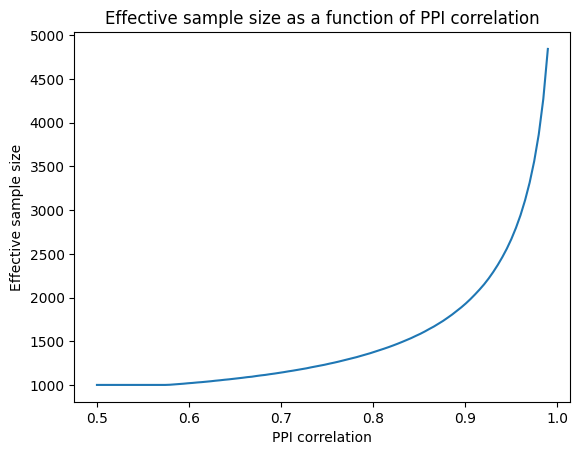

In [15]:
plt.plot(ppi_corrs, effective_ns)
plt.xlabel("PPI correlation")
plt.ylabel("Effective sample size")
plt.title("Effective sample size as a function of PPI correlation")
plt.show()